<a href="https://colab.research.google.com/github/maurofama99/ann_challenge/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ANNDL Challenge 1
Developed by : Mauro Famà, Sofia Martellozzo, Lorenzo Mondo \\
Group : cANNoli

##Set Up

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go inside the folder

In [ ]:
%cd /gdrive/My Drive/

Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import svm
from PIL import Image
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

Seed for reproducivity

In [5]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Suppress warnings

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Funtions to test the model on validation set and plot the confusion matrix \\
**Confusion Matrix** is a really important performance measurement for classification problems: it highliths in which classes the model responds worse and which better.

In [7]:
def plot_confusionMatrix(test_labels, test_predicted):
  
  cm = confusion_matrix(test_labels, test_predicted, labels=[0,1,2,3,4,5,6,7])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot()
  plt.show()
  return 

In [8]:
def testModel( valid_gen, model):

  # Predit test labels
  test_predicted = model.predict(valid_gen)
  test_predicted = np.argmax(test_predicted, axis=-1)
  
  # plot confusion matrix
  plot_confusionMatrix(valid_gen.classes, test_predicted)

  # display classification results
  print(classification_report(valid_gen.classes, test_predicted, target_names=labels))

###Load the dataset

In [ ]:
# Dataset folders 
dataset_dir = 'training_data_final'

# Load the dataset
if not os.path.exists(dataset_dir):
  !unzip training_dataset_homework1.zip

In [12]:
#get the number of img of each species
import fnmatch

count = [0,0,0,0,0,0,0,0]   # where I store the amount of images for each species
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

for i in range(len(labels)):
  dir_path = os.path.join(dataset_dir, labels[i])
  count[i] = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
  print('The number of img of', labels[i], 'is: ', count[i])

cumsum = np.cumsum(count)
print('Total amount of img is: ', cumsum[len(cumsum)-1] )

The number of img of Species1 is:  186
The number of img of Species2 is:  532
The number of img of Species3 is:  515
The number of img of Species4 is:  511
The number of img of Species5 is:  531
The number of img of Species6 is:  222
The number of img of Species7 is:  537
The number of img of Species8 is:  508
Total amount of img is:  3542


Inspect the data

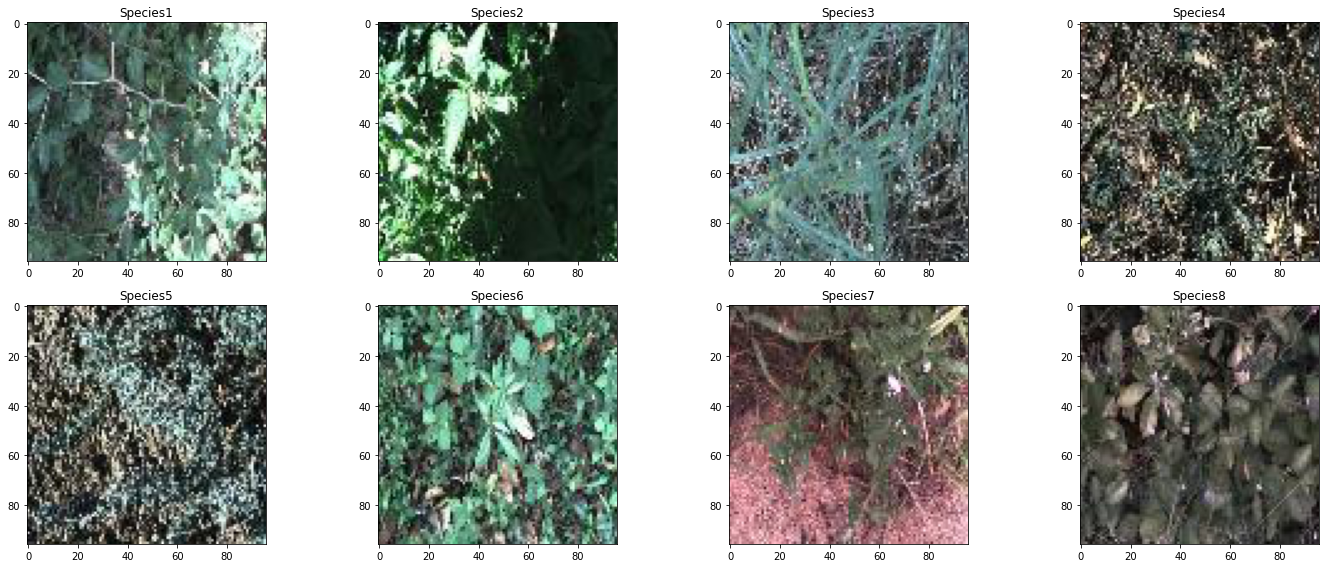

In [ ]:
import matplotlib.image as mpimg

num_row = 2
num_col = 4
fig,axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
i = 0

for label in labels:
  path = dataset_dir +"/"+ label +"/00005.jpg"
  image = mpimg.imread(path)
  ax = axes[i//num_col, i%num_col]
  ax.imshow(image)
  ax.set_title(label)
  i=i+1

plt.tight_layout()
plt.show()

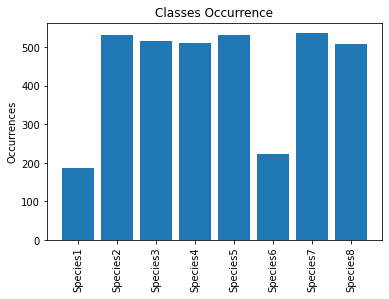

In [ ]:
plt.bar(labels, count)
plt.title("Classes Occurrence")
plt.ylabel("Occurrences")
plt.xticks(rotation=90)
plt.yticks
plt.show()

###Split data in train and test
Split the dataset in train (80%) and validation (20%) \\
Also apply as augmentations: 
- rotation (30)
- shift (50)
- zoom (0.3)
- horizontal flip
- vertical flip

In [13]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
valid_data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2) 

train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255,
                                        validation_split=0.2)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, 
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset="training")

valid_gen = valid_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [14]:
input_shape = (96, 96, 3)
epochs = 200

##Build Model

In [ ]:
def build_model_1(input_shape, convnet):

  dropout_rate = 0.2
  dropout_rate1 = 0.5

  # Build the model layer by layer
  input_layer = convnet.layers[0].input
  flat1 = Flatten()(convnet.layers[-1].output)
  flat1 = tfkl.Dropout(dropout_rate, seed=seed)(flat1)
  hidden_layer1 = tfkl.Dense(units=512, activation='relu', name='Hidden1', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(flat1)
  hidden_layer1 = tfkl.Dropout(dropout_rate, seed=seed)(hidden_layer1)
  hidden_layer2 = tfkl.Dense(units=256, activation='relu', name='Hidden2', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer1)
  hidden_layer2 = tfkl.Dropout(dropout_rate1, seed=seed)(hidden_layer2)
  output = tfkl.Dense(units=8, activation='softmax', name='Output', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer2)
  
  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output, name='model')

  # Compile the model
  learning_rate = 1e-5
  opt = tfk.optimizers.Adam(learning_rate)

  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')

  # Return the model
  return model

In [ ]:
def build_model_2(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    xc_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(xc_layer)

    layer1 = tfkl.Dense(units=512, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.2, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_model_3(input_shape, convnet):

  # Build the model
  input_layer = convnet.layers[0].input
  flat1 = Flatten()(convnet.layers[-1].output)
  hidden_layer1 = tfkl.Dense(units=700, activation='relu', name='Hidden1', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(flat1)
  hidden_layer2 = tfkl.Dense(units=350, activation='relu', name='Hidden2', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer1)
  output = tfkl.Dense(units=8, activation='softmax', name='Output', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer2)
  
  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output, name='model')

  
  # Compile the model
  learning_rate = 1e-4
  opt = tfk.optimizers.Adam(learning_rate)
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')
  
  # Return the model
  return model

###Callbacks

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

##Model 1
VGG16 architecture

In [ ]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(include_top=False, input_shape=input_shape)

Train all the layer, even the ones of the pre-trained model

In [ ]:
for layer in vgg16.layers:
	layer.trainable = True

In [ ]:
# Build model and visualize it
model_1 = build_model_1(input_shape, vgg16)
model_1.summary()

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='vgg16')

# Train the model
history = model_1.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model_1.save("savedModels/vgg16")

706/706 [==============================] - 318s 450ms/step


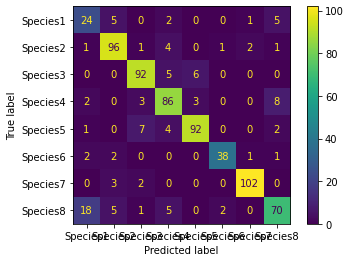

              precision    recall  f1-score   support

    Species1       0.50      0.65      0.56        37
    Species2       0.86      0.91      0.88       106
    Species3       0.87      0.89      0.88       103
    Species4       0.81      0.84      0.83       102
    Species5       0.91      0.87      0.89       106
    Species6       0.93      0.86      0.89        44
    Species7       0.96      0.95      0.96       107
    Species8       0.80      0.69      0.74       101

    accuracy                           0.85       706
   macro avg       0.83      0.83      0.83       706
weighted avg       0.86      0.85      0.85       706



In [35]:
testModel(valid_gen, model_1)

##Model 2
XCeption architecture

In [ ]:
xCeption = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

Train only the fully connected layers (which are not part of the pre-trained model)

In [ ]:
for layer in xCeption.layers:
    layer.trainable = False

In [ ]:
model2 = build_model_2(input_shape, xCeption)
model2.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='XCeption')

# Train the model
history = model2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model2.save("savedModels/XCeption")

In [ ]:
testModel(valid_gen, model2)

Then perform Fine tuing by unfreezing the layers of the xception architecture and re train the hole model with a lower learning rate

In [ ]:
model_2 = tfk.models.load_model("savedModels/XCeption")

unfreeze the layers

In [ ]:
model_2.get_layer('xception').trainable = True

In [ ]:
model_2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
model_2.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='xception_FineTuning')

# Train the model
history = model_2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model_2.save("savedModels/xception_FineTuning")

706/706 [==============================] - 44s 58ms/step


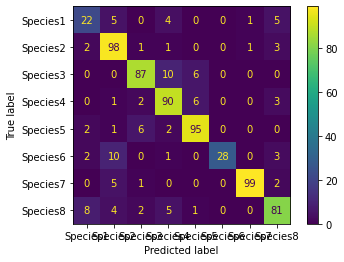

              precision    recall  f1-score   support

    Species1       0.61      0.59      0.60        37
    Species2       0.79      0.92      0.85       106
    Species3       0.88      0.84      0.86       103
    Species4       0.80      0.88      0.84       102
    Species5       0.88      0.90      0.89       106
    Species6       1.00      0.64      0.78        44
    Species7       0.98      0.93      0.95       107
    Species8       0.84      0.80      0.82       101

    accuracy                           0.85       706
   macro avg       0.85      0.81      0.82       706
weighted avg       0.86      0.85      0.85       706



In [38]:
testModel(valid_gen, model_2)

##Model 3
VGG19 architecture

In [ ]:
vgg19 = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

Train all the layer, even the ones of the pre-trained model

In [ ]:
for layer in vgg19.layers:
    layer.trainable = True

In [ ]:
model_3 = build_model_3(input_shape, vgg19)
model_3.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='vgg19')

# Train the model
history = model_3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model_3.save("savedModels/vgg19")

706/706 [==============================] - 84s 118ms/step


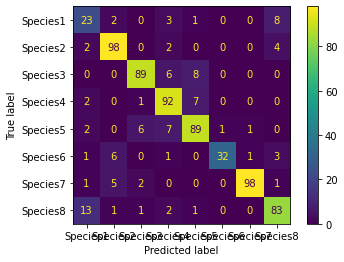

              precision    recall  f1-score   support

    Species1       0.52      0.62      0.57        37
    Species2       0.88      0.92      0.90       106
    Species3       0.90      0.86      0.88       103
    Species4       0.81      0.90      0.86       102
    Species5       0.84      0.84      0.84       106
    Species6       0.97      0.73      0.83        44
    Species7       0.98      0.92      0.95       107
    Species8       0.84      0.82      0.83       101

    accuracy                           0.86       706
   macro avg       0.84      0.83      0.83       706
weighted avg       0.86      0.86      0.86       706



In [39]:
testModel(valid_gen, model_3)

##Ensemble
Combine together the tree models computing the avarage output

In [19]:
first_model = tfk.models.load_model("savedModels/vgg16")
second_model = tfk.models.load_model("savedModels/xception_FineTuning")
third_model = tfk.models.load_model("savedModels/vgg19")

first_model._name = 'model1'
second_model._name = 'model2'
third_model._name = 'model3'

In [20]:
models = [first_model, second_model, third_model]

model_input = tf.keras.Input(shape=input_shape, name='input_layer')
model_outputs = [model(model_input) for model in models]

ensemble_output = tf.keras.layers.Average()(model_outputs)

ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.summary()

In [ ]:
ensemble_model.save("savedModels/EnsembleModel")

706/706 [==============================] - 174s 246ms/step


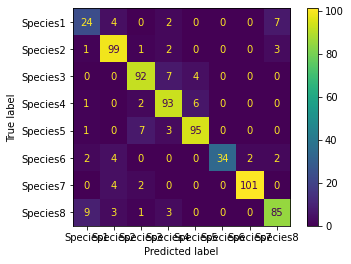

              precision    recall  f1-score   support

    Species1       0.63      0.65      0.64        37
    Species2       0.87      0.93      0.90       106
    Species3       0.88      0.89      0.88       103
    Species4       0.85      0.91      0.88       102
    Species5       0.90      0.90      0.90       106
    Species6       1.00      0.77      0.87        44
    Species7       0.98      0.94      0.96       107
    Species8       0.88      0.84      0.86       101

    accuracy                           0.88       706
   macro avg       0.87      0.86      0.86       706
weighted avg       0.89      0.88      0.88       706



In [40]:
testModel(valid_gen, ensemble_model)

##Models visualization

In [ ]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

In [17]:
from keras.utils.vis_utils import plot_model
import visualkeras
from PIL import ImageFont

In [18]:
font = ImageFont.truetype("arial.ttf", 12)

###VGG16

In [21]:
first_model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0    

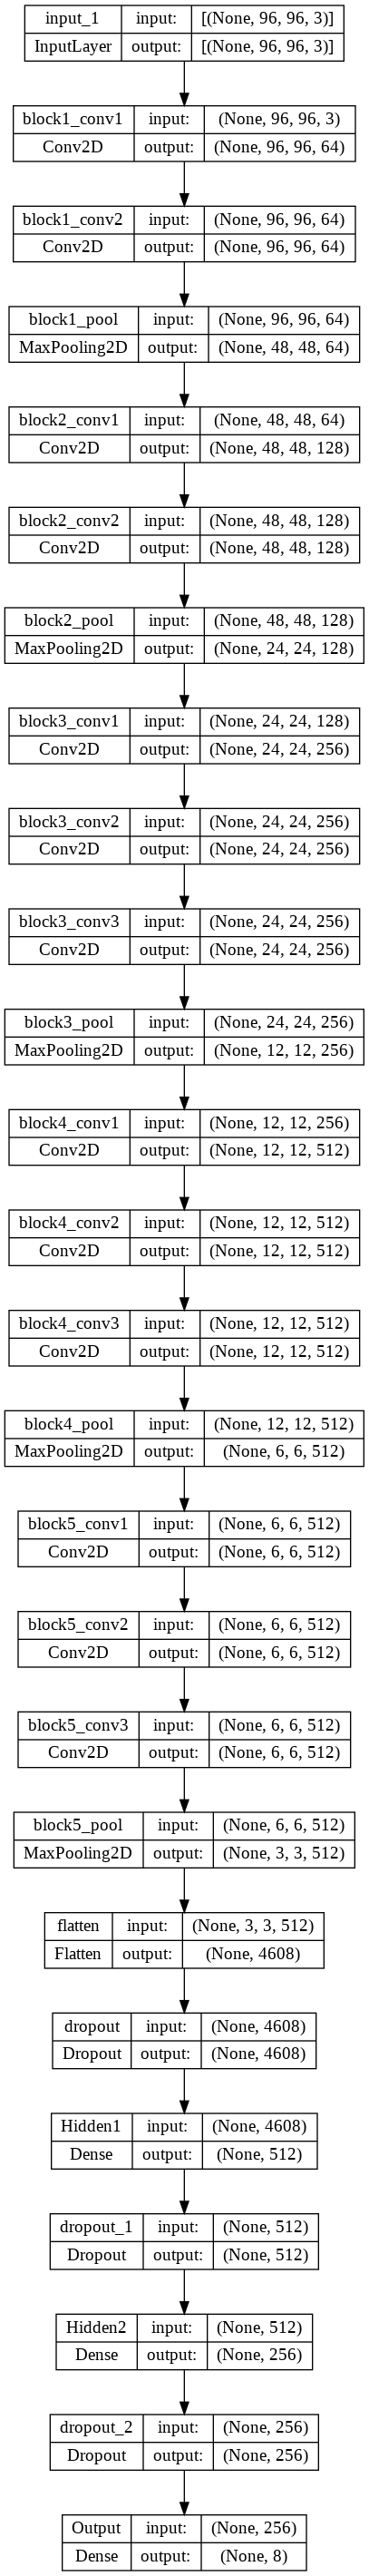

In [22]:
plot_model(first_model, show_shapes=True, show_layer_names=True)

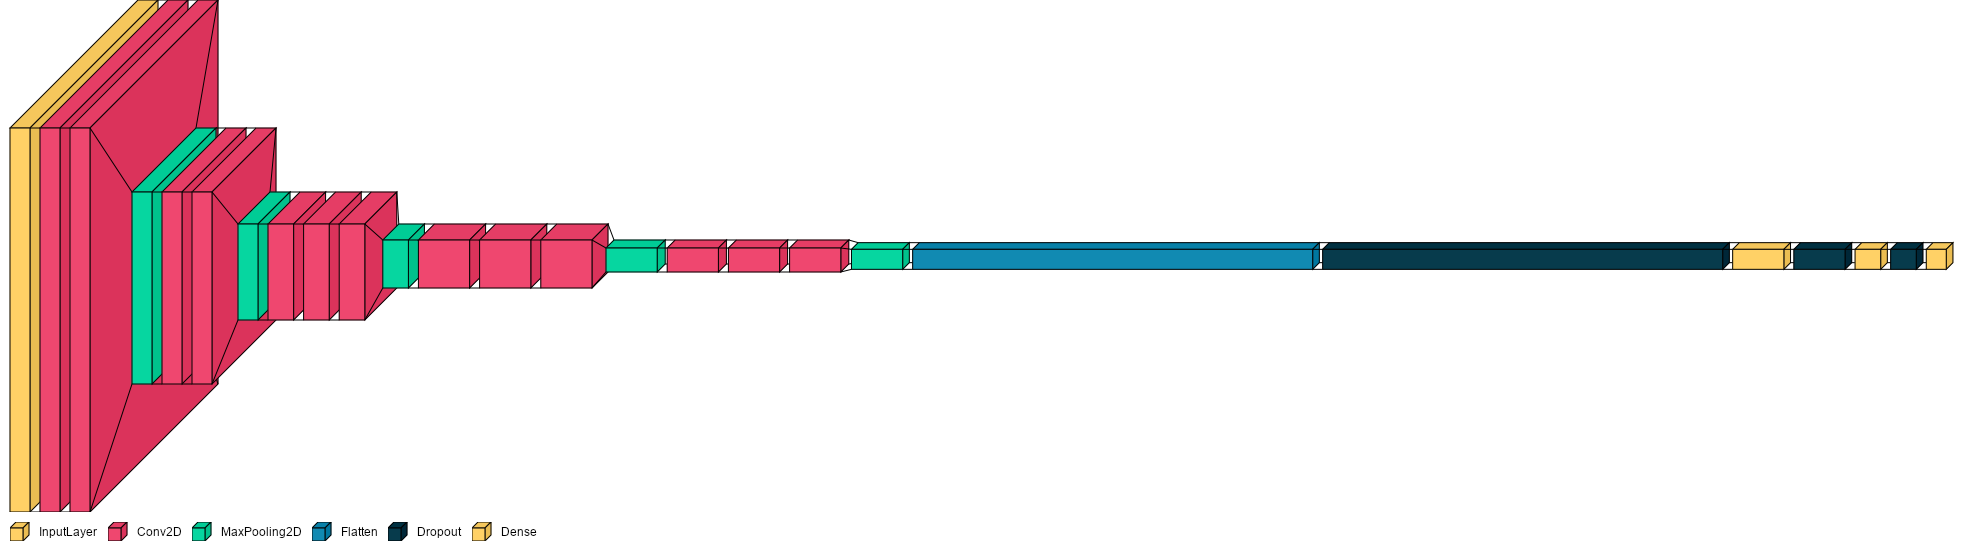

In [23]:
visualkeras.layered_view(first_model, legend=True, font = font)

###xCeption

In [24]:
second_model.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 Classifier (Dense)          (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0    

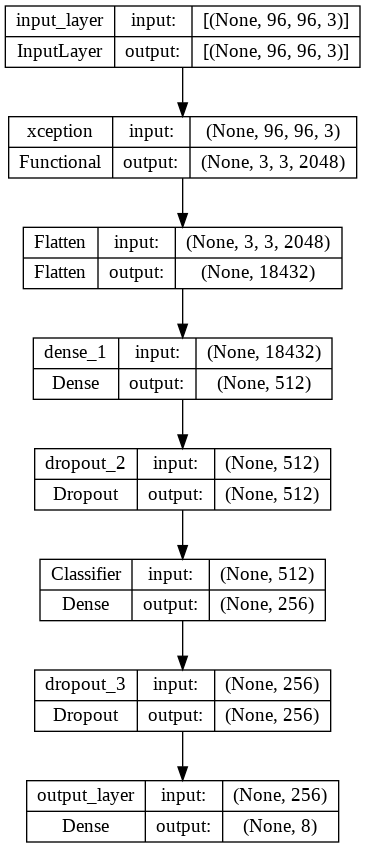

In [25]:
plot_model(second_model, show_shapes=True, show_layer_names=True)

xCeption seen as a unique box

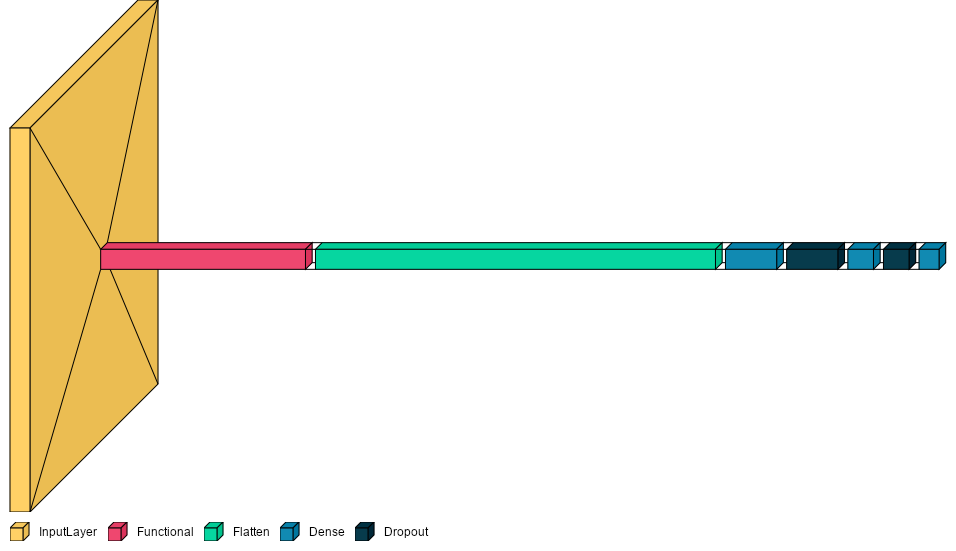

In [26]:
visualkeras.layered_view(second_model, legend=True, font = font)

visualization of all xCeption layers

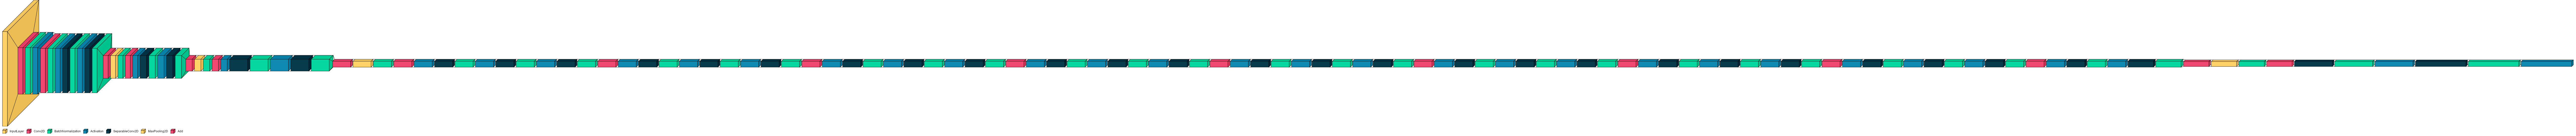

In [37]:
visualkeras.layered_view(xCeption, legend=True, font = font)

###VGG19

In [27]:
third_model.summary()

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0    

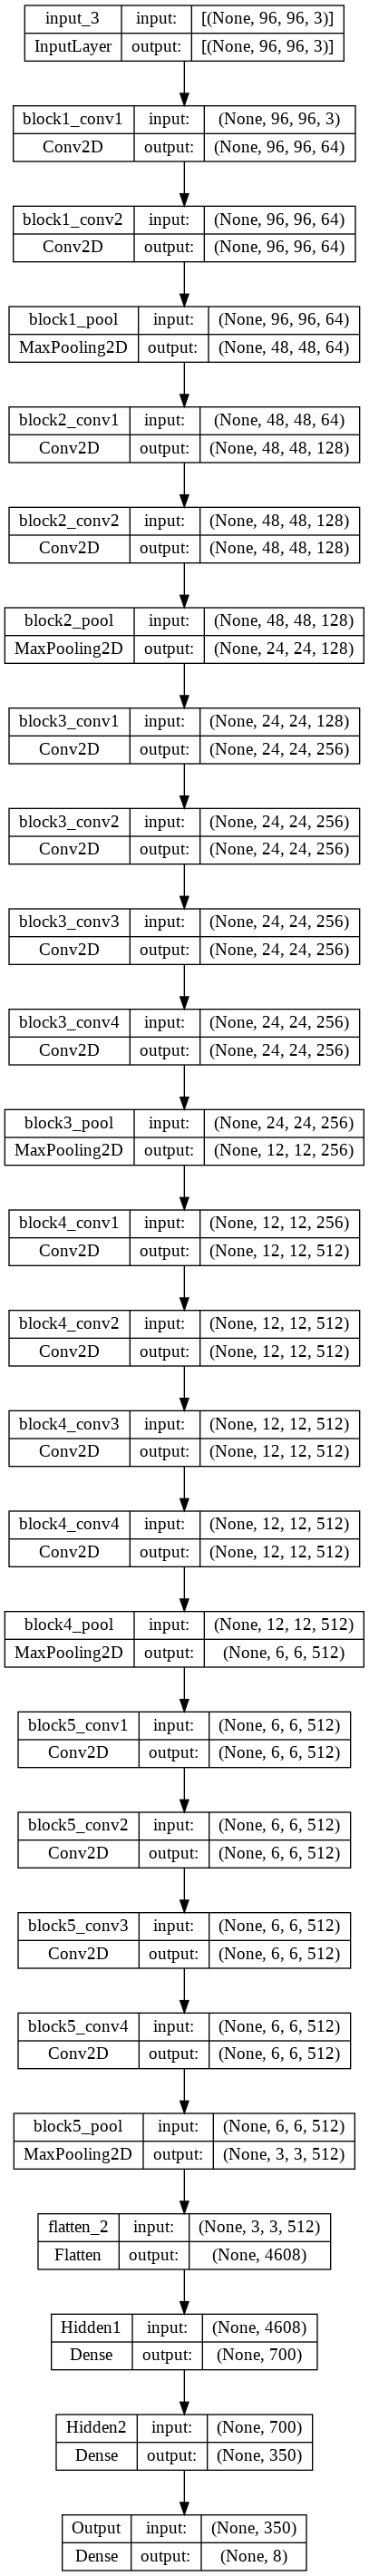

In [28]:
plot_model(third_model, show_shapes=True, show_layer_names=True)

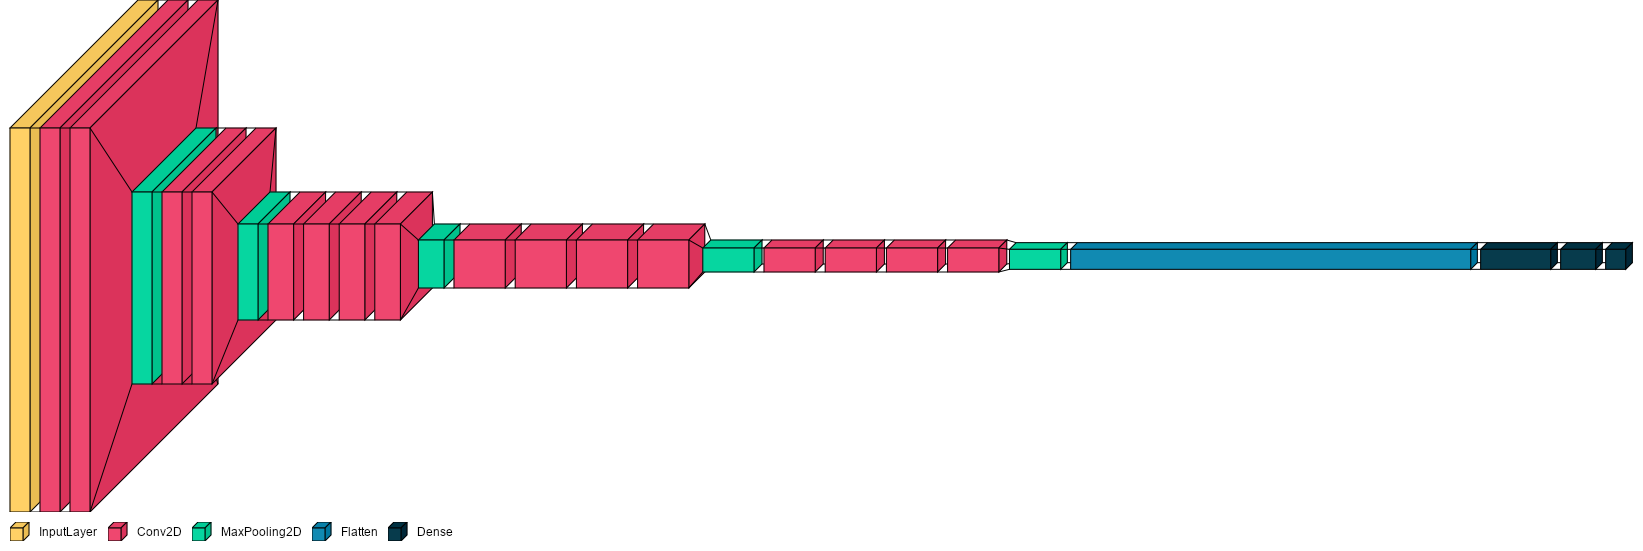

In [29]:
visualkeras.layered_view(third_model, legend=True, font = font)

###Ensemble

In [30]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model1 (Functional)            (None, 8)            17207880    ['input_layer[0][0]']            
                                                                                                  
 model2 (Functional)            (None, 8)            30432560    ['input_layer[0][0]']            
                                                                                                  
 model3 (Functional)            (None, 8)            23498842    ['input_layer[0][0]']            
                                                                                              

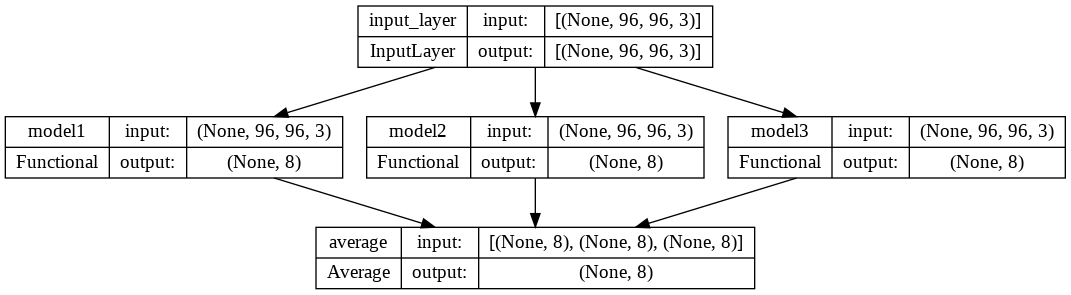

In [31]:
plot_model(ensemble_model, show_shapes=True, show_layer_names=True)

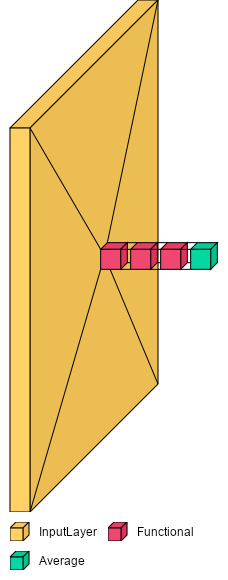

In [32]:
visualkeras.layered_view(ensemble_model, legend=True, font = font)